Vision Board Box Extractor V3 - Notebook Version
Original Vision Board:


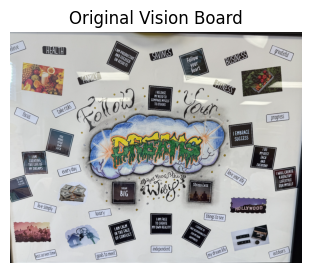

Found 2477 total contours
Filtered to 38 valid text boxes

Processing Results:
Session ID: 955b6417-a334-4e42-a54a-29fe79c79c6b
Number of text boxes found: 38

Displaying 38 extracted text boxes:


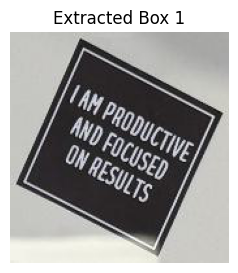

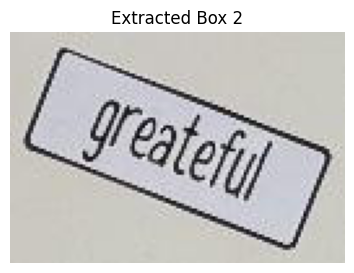

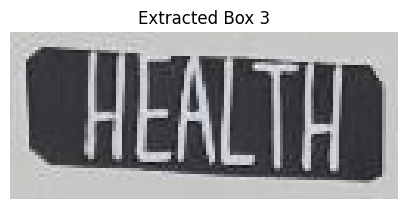

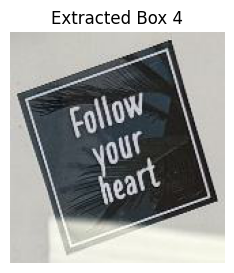

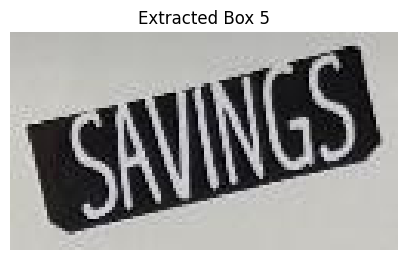

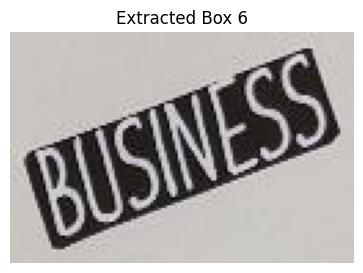

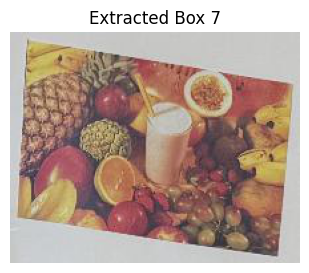

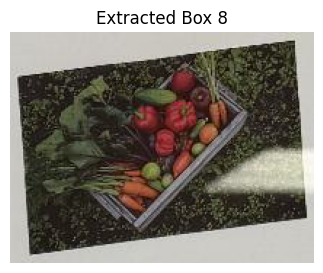

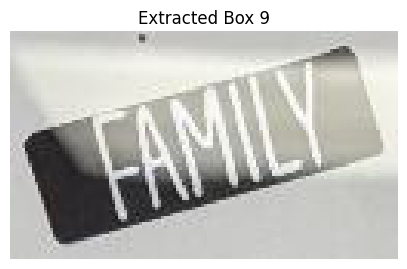

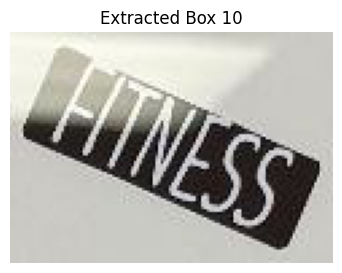

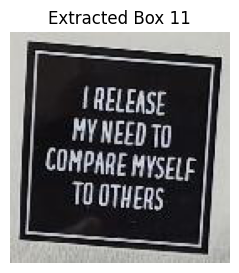

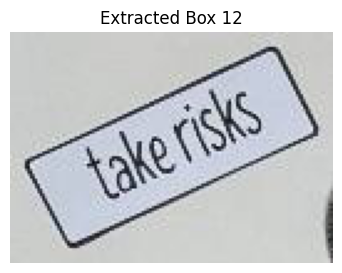

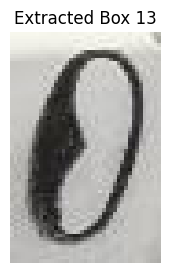

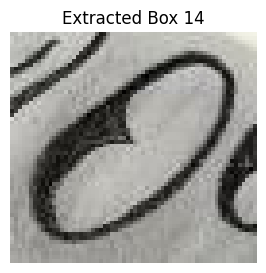

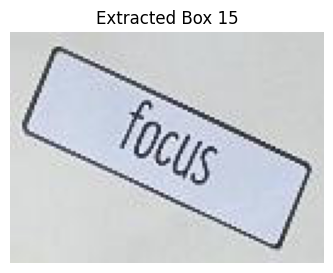

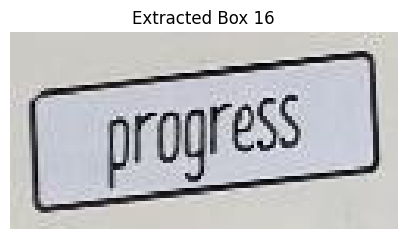

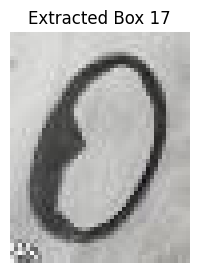

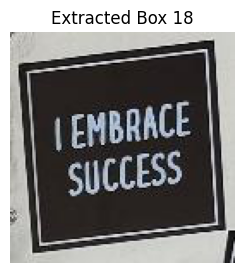

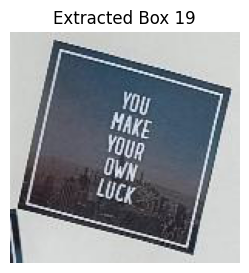

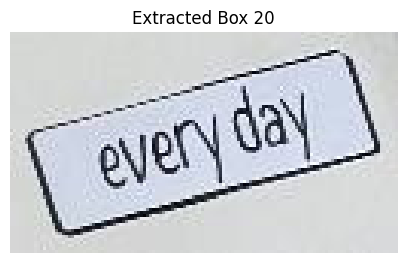

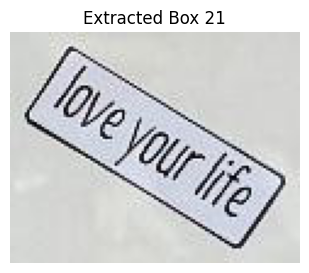

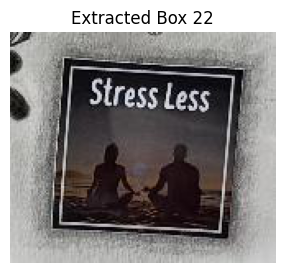

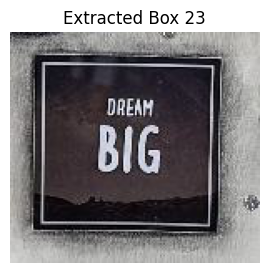

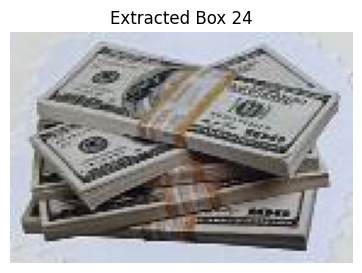

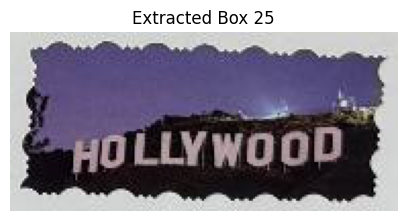

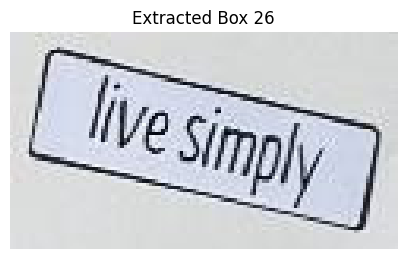

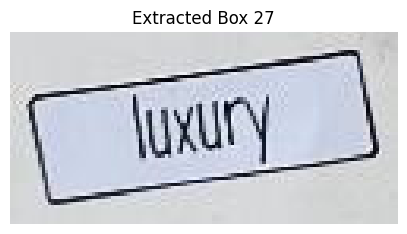

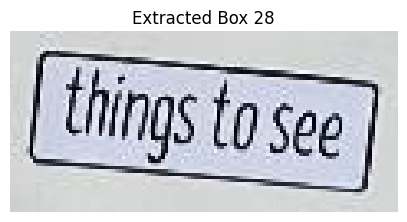

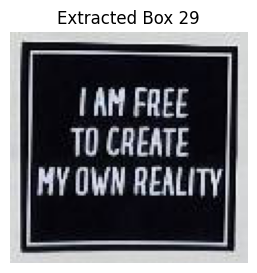

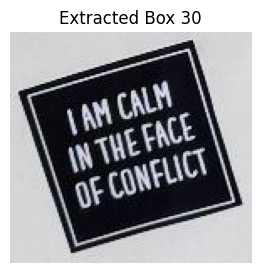

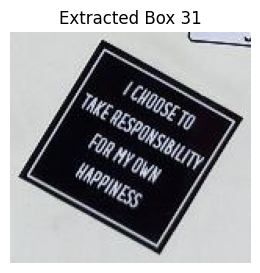

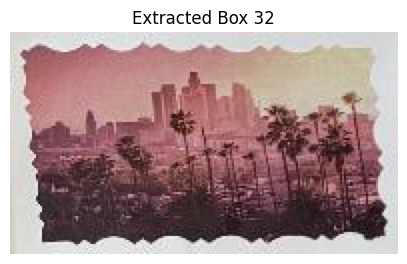

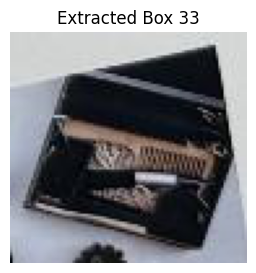

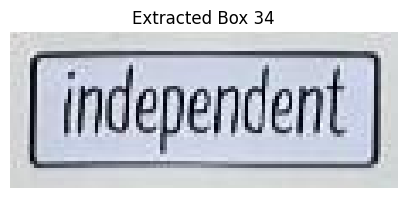

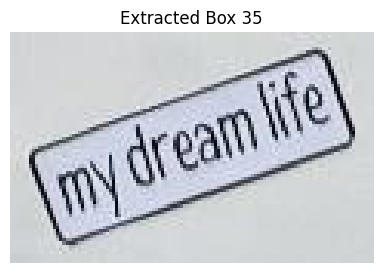

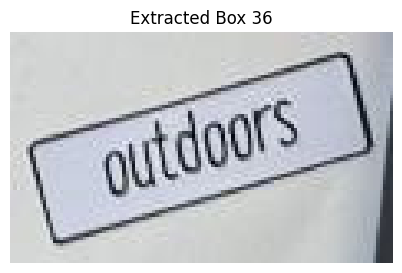

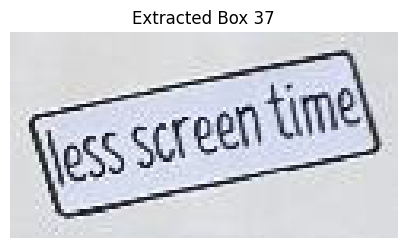

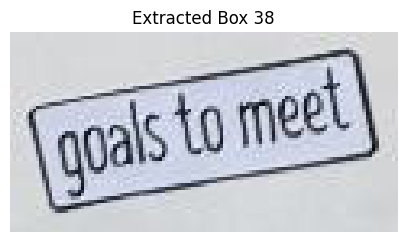


To use this code:
1. Update the image_path variable with your image path
2. Uncomment the testing section you want to use
3. Run the code to see results
Function availability check:
✓ base64_to_opencv_image - Available
✓ image_file_to_base64 - Available
✓ display_base64_image - Available
✓ extract_boxes_from_vision_board_base64 - Available
✓ process_vision_board - Available
✓ save_boxes_to_files - Available

All functions loaded successfully!
Ready to process vision board images!


In [8]:
# Vision Board Box Extractor V3 - Jupyter Notebook Version
# This code extracts text boxes from vision board images and returns them as base64 encoded images.

# Install required packages (uncomment if needed)
# !pip install opencv-python numpy pillow matplotlib

import cv2
import numpy as np
import uuid
from typing import List, Dict, Any
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import os

# Helper Functions
def base64_to_opencv_image(base64_string: str) -> np.ndarray:
    """Convert base64 string to OpenCV image"""
    try:
        if "," in base64_string:
            base64_string = base64_string.split(",")[1]
        
        image_data = base64.b64decode(base64_string)
        pil_image = Image.open(BytesIO(image_data))
        
        if pil_image.mode == "RGBA":
            pil_image = pil_image.convert("RGB")
        
        opencv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
        return opencv_image
    except Exception as e:
        raise ValueError(f"Invalid base64 image data: {str(e)}")

def image_file_to_base64(image_path: str) -> str:
    """Convert image file to base64 string for testing"""
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
        return f"data:image/jpeg;base64,{encoded_string}"

def display_base64_image(base64_string: str, title: str = "Image"):
    """Display base64 encoded image in notebook with smaller size"""
    # Remove data URL prefix if present
    if "," in base64_string:
        base64_string = base64_string.split(",")[1]
    
    # Decode base64 to image
    image_data = base64.b64decode(base64_string)
    image = Image.open(BytesIO(image_data))
    
    # Display using matplotlib with smaller figure size
    plt.figure(figsize=(5, 3))  # Reduced from (10, 6) to (5, 3)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main Processing Function
def is_rectangular_text_box(contour, image_shape, debug=False):
    """
    Determine if a contour represents a rectangular or square text box.
    
    Args:
        contour: OpenCV contour
        image_shape: Shape of the original image (height, width)
        debug: Print debug information
    
    Returns:
        Boolean indicating if this is likely a text box
    """
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate area and perimeter
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    if area == 0 or perimeter == 0:
        return False
    
    # 1. Size filters - more lenient
    min_area = 800  # Reduced minimum area
    max_area = (image_shape[0] * image_shape[1]) * 0.8  # Max 80% of image
    
    if area < min_area or area > max_area:
        return False
    
    # 2. Aspect ratio filter - now includes squares and more shapes
    aspect_ratio = max(w, h) / min(w, h)
    if aspect_ratio > 15:  # Only reject very thin lines
        return False
    
    # 3. More lenient rectangularity test for rounded corners
    epsilon = 0.04 * perimeter  # Increased epsilon for rounded corners
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    # Allow more variation in corners for rounded rectangles
    if len(approx) < 3 or len(approx) > 12:
        return False
    
    # 4. Extent test - more lenient
    extent = area / (w * h)
    if extent < 0.4:  # Reduced from 0.6 to 0.4
        return False
    
    # 5. Solidity test - more lenient for rounded corners
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    if hull_area > 0:
        solidity = area / hull_area
        if solidity < 0.7:  # Reduced from 0.85 to 0.7
            return False
    
    # 6. Minimum dimensions filter - more lenient
    min_width, min_height = 30, 30  # Reduced minimum dimensions
    if w < min_width or h < min_height:
        return False
    
    return True

def extract_boxes_from_vision_board_base64(image_base64: str, debug=False) -> List[str]:
    """
    Extract rectangular text boxes from a base64 encoded vision board image.
    
    Args:
        image_base64: Base64 encoded image string
        debug: Enable debug output for filtering process
    
    Returns:
        List of extracted boxes as base64 encoded strings
    """
    image = base64_to_opencv_image(image_base64)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Enhanced preprocessing for better edge detection
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use adaptive threshold for better results with varying lighting
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    
    # Apply morphological operations to clean up the image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours to find rectangular text boxes
    valid_contours = []
    for i, contour in enumerate(contours):
        if is_rectangular_text_box(contour, gray.shape, debug=debug):
            valid_contours.append(contour)
    
    if debug:
        print(f"Found {len(contours)} total contours")
        print(f"Filtered to {len(valid_contours)} valid text boxes")
    
    # Sort by vertical position (top to bottom)
    valid_contours = sorted(valid_contours, key=lambda c: cv2.boundingRect(c)[1])
    
    box_base64_list = []
    
    for i, contour in enumerate(valid_contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        # Add small padding around the detected box
        padding = 5
        x_padded = max(0, x - padding)
        y_padded = max(0, y - padding)
        w_padded = min(image_rgb.shape[1] - x_padded, w + 2 * padding)
        h_padded = min(image_rgb.shape[0] - y_padded, h + 2 * padding)
        
        box = image_rgb[y_padded:y_padded+h_padded, x_padded:x_padded+w_padded]
        
        # Convert box to base64
        pil_image = Image.fromarray(box)
        buffer = BytesIO()
        pil_image.save(buffer, format='JPEG')
        img_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
        box_base64_list.append(f"data:image/jpeg;base64,{img_base64}")
        
    return box_base64_list

def process_vision_board(image_base64: str, filename: str = "image.jpg", debug: bool = False) -> Dict[str, Any]:
    """
    Process vision board image and extract rectangular text boxes.
    
    Args:
        image_base64: Base64 encoded image string
        filename: Optional filename for reference
        debug: Enable debug output for the filtering process
        
    Returns:
        Dictionary containing session_id, number of boxes found, and box information with base64 images
    """
    if not image_base64:
        raise ValueError("No image data provided")
    
    session_id = str(uuid.uuid4())
    
    try:
        box_base64_list = extract_boxes_from_vision_board_base64(image_base64, debug=debug)
        
        results = []
        for i, box_base64 in enumerate(box_base64_list):
            results.append({
                "id": i + 1,
                "image": box_base64
            })
        
        return {
            "session_id": session_id,
            "filename": filename,
            "num_boxes_found": len(box_base64_list),
            "boxes": results
        }
        
    except Exception as e:
        raise Exception(f"Processing error: {str(e)}")

def save_boxes_to_files(result_data, output_dir="extracted_boxes"):
    """Save extracted boxes as individual image files"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    saved_files = []
    
    for box in result_data['boxes']:
        # Remove data URL prefix
        base64_string = box['image'].split(",")[1] if "," in box['image'] else box['image']
        
        # Decode and save
        image_data = base64.b64decode(base64_string)
        filename = f"{output_dir}/box_{box['id']}.jpg"
        
        with open(filename, "wb") as f:
            f.write(image_data)
        
        saved_files.append(filename)
    
    return saved_files

# Testing Section
if __name__ == "__main__":
    print("Vision Board Box Extractor V3 - Notebook Version")
    print("=" * 50)
    
    # EXAMPLE USAGE:
    
    # Option 1: Test with a local image file
    # Replace with the actual path to your vision board image
    image_path = "/Users/angelo/downloads/Coding3/refined-extract-boxes/images/storyboard-1.png"
    
    # Uncomment and modify the following code to test with your image:
    
    try:
        # Convert image to base64
        image_base64 = image_file_to_base64(image_path)
        
        # Display original image
        print("Original Vision Board:")
        display_base64_image(image_base64, "Original Vision Board")
        
        # Process the image with debug enabled to see filtering details
        result = process_vision_board(image_base64, "test_vision_board.jpg", debug=True)
        
        print(f"\nProcessing Results:")
        print(f"Session ID: {result['session_id']}")
        print(f"Number of text boxes found: {result['num_boxes_found']}")
        
        # Display all extracted boxes
        if result['num_boxes_found'] > 0:
            print(f"\nDisplaying {result['num_boxes_found']} extracted text boxes:")
            
            for box in result['boxes']:
                display_base64_image(box['image'], f"Extracted Box {box['id']}")
        else:
            print("No text boxes detected. Try adjusting the filtering parameters.")
        
        # Optionally save boxes to files
        # saved_files = save_boxes_to_files(result)
        # print(f"\nSaved {len(saved_files)} boxes to files")
        
    except FileNotFoundError:
        print(f"Error: Could not find image file at {image_path}")
        print("Please update the image_path variable with the correct path to your image.")
    except Exception as e:
        print(f"Error: {e}")
    
    
    # Option 2: Test with base64 string directly
    # If you already have a base64 encoded image, use it like this:
    """
    image_base64_direct = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD..."
    
    try:
        result = process_vision_board(image_base64_direct, "direct_test.jpg")
        print(f"Processing Results:")
        print(f"Session ID: {result['session_id']}")
        print(f"Number of boxes found: {result['num_boxes_found']}")
        
        # Display extracted boxes
        for box in result['boxes']:
            display_base64_image(box['image'], f"Extracted Box {box['id']}")
            
    except Exception as e:
        print(f"Error: {e}")
    """
    
    print("\nTo use this code:")
    print("1. Update the image_path variable with your image path")
    print("2. Uncomment the testing section you want to use")
    print("3. Run the code to see results")


# Simple test function to verify everything is working
def test_functionality():
    """Test that all functions are properly defined"""
    functions = [
        'base64_to_opencv_image',
        'image_file_to_base64', 
        'display_base64_image',
        'extract_boxes_from_vision_board_base64',
        'process_vision_board',
        'save_boxes_to_files'
    ]
    
    print("Function availability check:")
    for func_name in functions:
        if func_name in globals():
            print(f"✓ {func_name} - Available")
        else:
            print(f"✗ {func_name} - Missing")
    
    print("\nAll functions loaded successfully!")
    print("Ready to process vision board images!")

# Run the test
test_functionality()